# Employing a Neural Network to Make Predictions on the Pima Indians Diabetes Dataset

In this program we are going to make predictions on the Pima Indians Diabetes dataset after training a simple neural network. The dataset consists of 768 samples of eight diagnostic measurements (features) along with a label indicating whether or not the patient developed diabetes within 5 years of the initial measurements.

We begin by reading the diabetes dataset into a Pandas dataframe and displaying.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score
from keras.models import Sequential
from keras.layers import Dense
import warnings
warnings.filterwarnings("ignore")

df = pd.read_csv('diabetes.csv')
df.head(8)

Using TensorFlow backend.


,pregnancies,glucose,diastolic,triceps,insulin,bmi,dpf,age,diabetes
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1
5,5,116,74,0,0,25.6,0.201,30,0
6,3,78,50,32,88,31.0,0.248,26,1
7,10,115,0,0,0,35.3,0.134,29,0


Each sample in the dataset has eight features. 'glucose' represents blood glucose concentration, 'diastolic' is diastolic blood pressure, 'triceps' represents the skin fold thickness measured on the triceps, 'insulin' is blood insulin concentration, and 'dpf' indicates the genetic predisposition of the patient for diabetes.

Display histogram plots of the features to visualise their distributions.

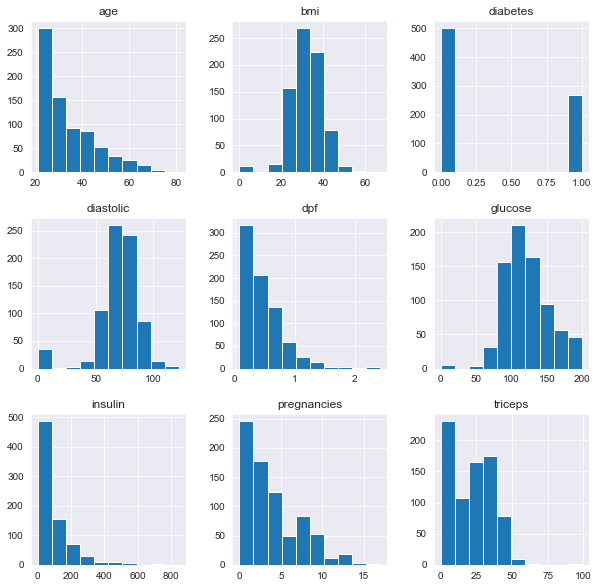

In [2]:
sns.set_style('darkgrid')
fig = plt.figure(figsize = (10, 10))
ax = fig.gca()
df.hist(ax = ax)
plt.show()

There are several insights we can gain from these plots. The patients in the datset were mostly young, and several of the variables have a normal distribution but with impossible values. BMI, diastolic blood pressure, and blood glucose concentration cannot be zero.

We can visualise the relationships between the features and the target variable with density plots.

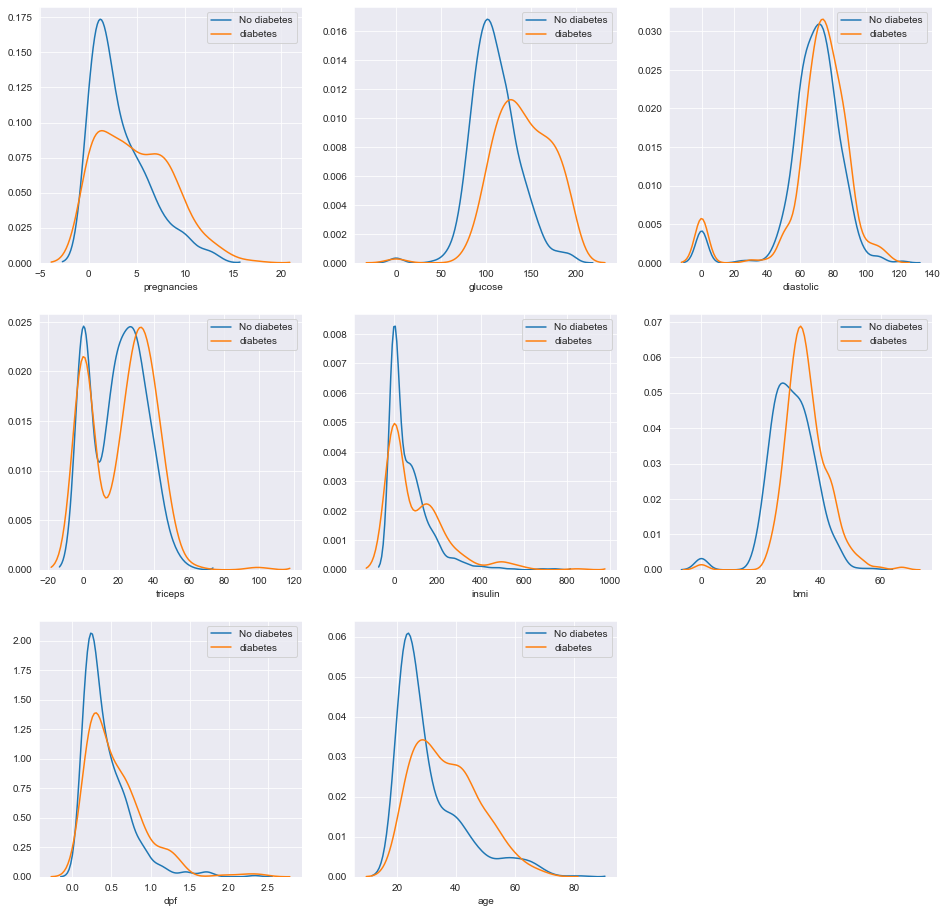

In [3]:
# get column names
column_names = df.columns
# create a 3 x 3 subplot
plt.subplots(3, 3, figsize = (16, 16))
# for every column...
for i in range(len(df.columns)):
    # retrieve axis (index starts at 1)
    ax = plt.subplot(3, 3, i+1)
    # produce density plot for y = 0 samples
    # df.loc[df['diabetes'] == 0] selects all rows of df for which df['diabetes'] == 0 is true
    sns.distplot(df.loc[df['diabetes'] == 0][column_names[i]], hist = False, label = 'No diabetes')
    # produce density plot for y = 1 samples
    sns.distplot(df.loc[df['diabetes'] == 1][column_names[i]], hist = False, label = 'diabetes')
    ax.legend()

# hide the final plot, since it has no data
plt.subplot(3, 3, 9).set_visible(False)
plt.show()

From the plots we can see that individuals with diabetes have a higher mean blood glucose concentration, diastolic blood pressure, triceps skin fold thickness, and are on average older than those who do not have diabetes. Also, patients with diabetes have a wider range of ages and blood glucose concentrations.

Let's have a look at some basic statistics for the dataset. 

In [4]:
df.describe()

,pregnancies,glucose,diastolic,triceps,insulin,bmi,dpf,age,diabetes
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


We have confirmation that there are zero value entries for many of the features which cannot be zero. Let's see just how many zero values there are for each feature.

In [5]:
print('Number of zero values per column')
for column in column_names:
    print('{}: {}'.format(column, sum(df[column] == 0)))

Number of zero values per column
pregnancies: 111
glucose: 5
diastolic: 35
triceps: 227
insulin: 374
bmi: 11
dpf: 0
age: 0
diabetes: 500


We are going to impute all zero values for features which cannot take zero values with the mean value for that particular feature. We first replace all zeros with NaN values and use the fillna method to replaces these with the means.

In [6]:
# get columns (features) which cannot take a zero value
columns_r = ['glucose', 'diastolic', 'triceps', 'insulin', 'bmi']
# for each of these columns...
for col in columns_r:
    # replace these zeros with NaN values
    df[col] = df[col].replace(0, np.nan)
    # use the fillna method to replace NaN values with the mean of the feature
    df[col] = df[col].fillna(df[col].mean())

Assign the features to X and the target outcomes to y. We will scale the data using StandardScaler and then split into training and testing sets.

In [7]:
# assign X and y
X = df.drop('diabetes', axis = 1)
y = df['diabetes']

# scale the dataset (X only)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# split dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size = 0.2, random_state = 3)

To build a neural network with a linear set of layers we first initiate a Sequential model and add layers to it. We are going to use Dense layers, which have the property that all of their neurons are connected to those in the next layer. The first hidden layer will have 32 neurons and will take samples with eight features as inputs. The second hidden layer will contain 16 neurons. Both the hidden layer neurons will use the ReLU activation function, which is usually chosen in these layers instead of the sigmoid activation function for certain properties. The latter is chosen for the output layer activation as it permits the easy prediction of the binary classification.

In [8]:
# create Sequential model
model = Sequential()
# add the first hidden layer of 16 neurons
model.add(Dense(32, activation = 'relu', input_dim = 8))
# add the second hidden layer, also of 16 neurons
model.add(Dense(16, activation = 'relu'))
# add the output layer, consisting of a single sigmoid neuron
model.add(Dense(1, activation = 'sigmoid'))

Before training the model we need to define the parameters we are going to use with the compile method. The adam optimiser employs stochastic gradient descent. The cost function we will employ is known as the cross-entropy cost function. The accuracy metric measures the percentage of correctly classified training samples. 

In [9]:
# compile the model
model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
# train the model for 200 epochs
model.fit(X_train, y_train, epochs = 200, verbose = 0)

In [10]:
print('Training accuracy: {:.1f}%'.format(model.evaluate(X_train, y_train)[1]*100))
print('Testing accuracy: {:.1f}%'.format(model.evaluate(X_test, y_test)[1]*100))

614/614 [==============================] - 0s 244us/step
Training accuracy: 91.2%
154/154 [==============================] - 0s 60us/step
Testing accuracy: 74.0%


As we would expect, model performance on the test data is worse than on the training data. 

We can further evaluate the model with the help of the confusion matrix.

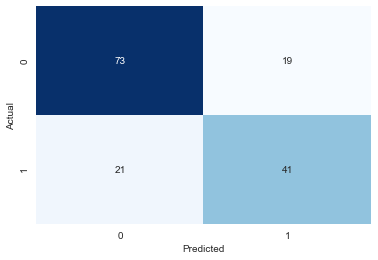

In [11]:
# generate confusion matrix
y_pred = model.predict_classes(X_test)
ax = sns.heatmap(confusion_matrix(y_test, y_pred), annot = True, cbar = False, cmap = 'Blues')
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')
plt.show()

We will conclude the evaluation of the model by generating a Receiver Operating Characteristic (ROC) curve. We plot the true positive rate against the false positive rate as the output neuron threshold for classification is varied. A large Area Under the Curve (AUC) indicates that the model is able to distinguish between the two classes with a high accuracy, whereas a low AUC suggests that the model's predictions are unreliable. 

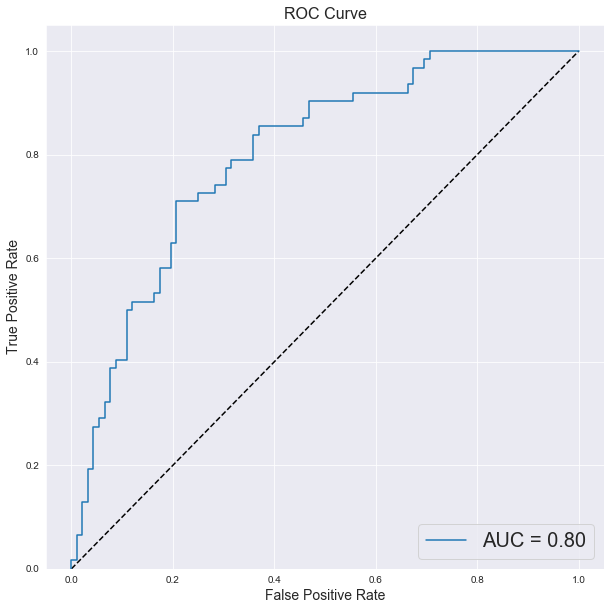

In [12]:
# get the predicted probabilities of each sample
y_pred_probs = model.predict(X_test)
# get the false positive and true positive rates
fpr, tpr, thresholds = roc_curve(y_test, y_pred_probs)

# plot ROC curve
fig = plt.figure(figsize = (10, 10))
ax = fig.add_subplot(111)
ax.plot([0, 1], [0, 1], 'k--')
ax.set_xlabel('False Positive Rate', fontsize = 14)
ax.set_ylabel('True Positive Rate', fontsize = 14)
ax.set_title('ROC Curve', fontsize = 16)
ax.set_ylim(0,)

# compute area under curve score
auc_score = roc_auc_score(y_test, y_pred_probs)
# plot ROC curve on ax
ax.plot(fpr, tpr, label = 'AUC = {:.2f}'.format(auc_score))
plt.legend(loc = 'lower right', prop = {'size': 20})
plt.show()

An AUC of 0.8 indicates that the model is able to distinguish between samples of the two classes, and make reliable predictions.